# ValidMLInference: example 1

In [78]:
from ValidMLInference import ols, ols_bca, ols_bcm, one_step_unlabeled
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Parameters for simulation

In [79]:
# Parameters for simulation
nsim = 1000
n = 16000
m = 1600
p = 0.05
kappa = 1 #importance of measurement error relative to sampling error 
p1 = (kappa / np.sqrt(n)) / (1.0 - p)
b0 = 1.0
b1 = 4.0

# Storage arrays
B = np.zeros((nsim, 9, 2))  # Coefficients (β0, β1) for each method and simulation
S = np.zeros((nsim, 9, 2))  # Standard errors

### Data Generation

In [ ]:
def generate_data(n, m, p, p1, beta0, beta1):
    """
    Generates simulated data.
    
    Parameters:
      n, m: Python integers (number of training and test samples)
      p, p1: floats
      beta0, beta1: floats
    
    Returns:
      A tuple: ((train_Y, train_X), (test_Y, test_Xhat, test_X))
      where train_X and test_Xhat include a constant term as the second column.
    """
    N = n + m
    Y = np.random.randn(N)
    X = (np.random.rand(N) < p).astype(float)
    # Data generating process: note that Y depends on X both additively and multiplicatively.
    Y = Y + beta0 + beta1 * X + X * Y
    # Introduce measurement error: flip X with probability p1.
    Xhat = X.copy()
    flips = np.random.rand(N) < p1
    Xhat[flips] = 1 - X[flips]
    
    # Training data (unlabeled): use Xhat (with constant)
    train_Y = Y[:n]
    train_X = np.column_stack((Xhat[:n], np.ones(n)))
    
    # Test data (labeled): we have both Xhat and the true X.
    test_Y = Y[n:n+m]
    test_Xhat = np.column_stack((Xhat[n:n+m], np.ones(m)))
    test_X = np.column_stack((X[n:n+m], np.ones(m)))
    
    return ((train_Y, train_X), (test_Y, test_Xhat, test_X))


def update_results(B, S, b, V, row, column):
    """
    Saves the coefficient estimates and their standard errors into B and S.
    
    Parameters:
        B, S  : arrays with shape (nsim, 13, 2)
        b     : estimated coefficients (length 2)
        V     : estimated variance-covariance matrix (2x2)
        row   : simulation index (0-indexed)
        column: method index (0-indexed)
    """
    for j in range(2):
        B[row, column, j] = b[j]
        S[row, column, j] = np.sqrt(V[j, j])

In [ ]:
#simulation loop
for i in range(nsim):
    # --- Generate data ---
    data = generate_data(n, m, p, p1, b0, b1)
    train_data = data[0]  # (train_Y, train_X)
    test_data = data[1]   # (test_Y, test_Xhat, test_X)

    # --- OLS on generated (unlabeled) data ---
    b, V, _ = ols(train_data[0], train_data[1])
    update_results(B, S, b, V, i, 0)

    # --- OLS on labeled data (using true X) ---
    # Note: test_data[0] is test_Y and test_data[2] is test_X (true X with constant).
    b, V, _ = ols(test_data[0], test_data[2])
    update_results(B, S, b, V, i, 1)

    # --- Additive bias-correction (BCA) ---
    # Compute the false positive rate (fpr) using the test (labeled) data.
    fpr = np.mean(test_data[1][:, 0] * (1 - test_data[2][:, 0]))
    # Try three different FPR adjustments.
    for j in range(3):  # j = 0, 1, 2
        fpr_bayes = (fpr + j/m) / (1 + 1/m)
        b, V = ols_bca(train_data[0], train_data[1], fpr_bayes, m)
        update_results(B, S, b, V, i, 2 + j)  # Columns 2, 3, 4
    
    # --- Multiplicative bias-correction (BCM) ---
    # Re-calculate fpr (same as above)
    fpr = np.mean(test_data[1][:, 0] * (1 - test_data[2][:, 0]))
    for j in range(3):  # j = 0, 1, 2
        fpr_bayes = (fpr + j/m) / (1 + 1/m)
        b, V = ols_bcm(train_data[0], train_data[1], fpr_bayes, m)
        update_results(B, S, b, V, i, 5 + j)  # Columns 5, 6, 7

    # --- One-step estimation (unlabeled) ---
    b, V = one_step_unlabeled(train_data[0], train_data[1])
    update_results(B, S, np.array(b), np.array(V), i/, 8)
    # Progress update every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Simulation {i + 1} completed.")


Simulation 100 completed.
Simulation 200 completed.
Simulation 300 completed.
Simulation 400 completed.
Simulation 500 completed.
Simulation 600 completed.
Simulation 700 completed.
Simulation 800 completed.
Simulation 900 completed.
Simulation 1000 completed.


In [35]:
def coverage(bgrid, b, se):
    """
    Computes the coverage probability for a grid of β values.
    
    For each value in bgrid, it computes the fraction of estimates b that
    lie within 1.96*se of that value.
    """
    cvg = np.empty_like(bgrid)
    for i, val in enumerate(bgrid):
        cvg[i] = np.mean(np.abs(b - val) <= 1.96 * se)
    return cvg

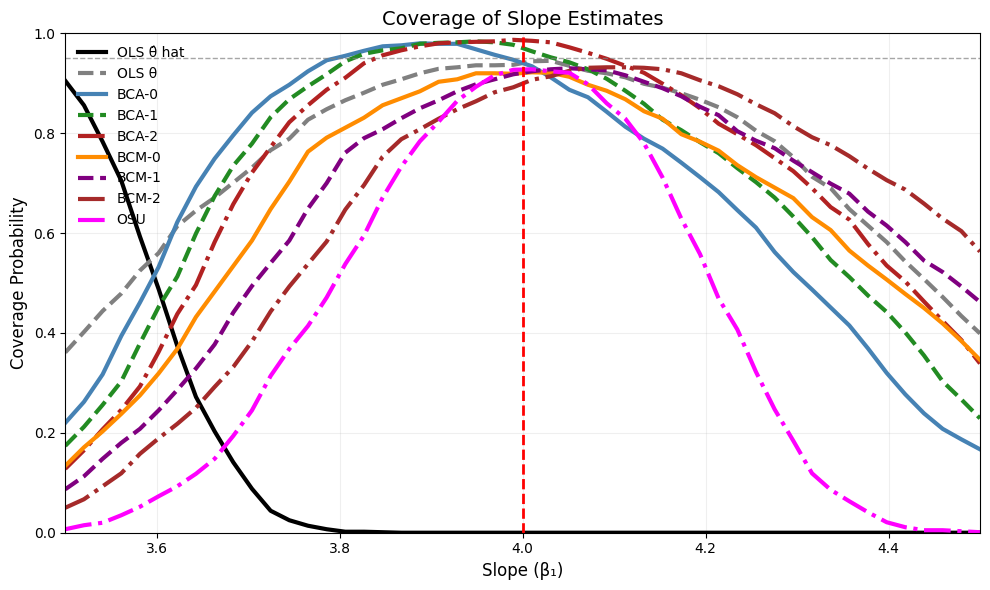

In [82]:
true_beta1 = 4.0
bgrid = np.linspace(3.5, 4.5)

plt.figure(figsize=(10,6))

methods = {
    "OLS θ̂": (0, "OLS θ̂ hat", "black", "-", 3),
    "OLS θ":  (1, "OLS θ", "gray", "--", 3),
    "BCA-0":  (2, "BCA-0", "steelblue", "-", 3),
    "BCA-1":  (3, "BCA-1", "forestgreen", "--", 3),
    "BCA-2":  (4, "BCA-2", "firebrick", "-.", 3),
    "BCM-0":  (5, "BCM-0", "darkorange", "-", 3),
    "BCM-1":  (6, "BCM-1", "purple", "--", 3),
    "BCM-2":  (7, "BCM-2", "brown", "-.", 3),
    "OSU":  (8, "OSU", "fuchsia", "-.", 3),

}

for key, (col, label, color, linestyle, lw) in methods.items():
    b_estimates = B[:, col, 0]  # slope
    se_estimates = S[:, col, 0]
    cov_prob = coverage(bgrid, b_estimates, se_estimates)
    plt.plot(bgrid, cov_prob, label=label, color=color, linestyle=linestyle, linewidth=lw)

plt.axvline(1.0, color='black', linestyle=':', linewidth=2)
plt.axhline(0.95, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.ylim(0, 1)
plt.xlabel("Slope (β₁)", fontsize=12)
plt.ylabel("Coverage Probability", fontsize=12)
plt.title("Coverage of Slope Estimates", fontsize=14)
plt.legend(loc='upper left', frameon=False)
plt.grid(alpha=0.2)
plt.xlim(3.5, 4.5)
plt.tight_layout()
plt.axvline(x=4, color='red', linestyle='--', linewidth=2, label=r'$\beta_1 = 4$')
plt.show()

### Recovering coefficients and standard errors:

Recall that the dataframe B stores our coefficient results while the dataframe S stores our standard errors. We can summarize our simulation results by averaging over the columns which store the results for the different simulation methods.

In [84]:
nsim, nmethods, ncoeff = B.shape

method_names = [
    "OLS (unlabeled)",
    "OLS (labeled)",
    "BCA (j=0)",
    "BCA (j=1)",
    "BCA (j=2)",
    "BCM (j=0)",
    "BCM (j=1)",
    "BCM (j=2)",
    "1-Step"
]

results = []

for i in range(nmethods):
    row = {"Method": method_names[i]}
    
    for j, coef in enumerate(["Beta1", "Beta0"]):
        estimates = B[:, i, j]
        ses = S[:, i, j]
        mean_est = np.nanmean(estimates)
        mean_se = np.nanmean(ses)
        lower = np.percentile(estimates, 2.5)
        upper = np.percentile(estimates, 97.5)
        
        row[f"Est({coef})"] = f"{mean_est:.3f}"
        row[f"SE({coef})"] = f"{mean_se:.3f}"
        row[f"95% CI ({coef})"] = f"[{lower:.3f}, {upper:.3f}]"
    
    results.append(row)

df_results = pd.DataFrame(results).set_index("Method")
print(df_results)

                Est(Beta1) SE(Beta1)  95% CI (Beta1) Est(Beta0) SE(Beta0)  \
Method                                                                      
OLS (unlabeled)      3.448     0.078  [3.304, 3.595]      1.002     0.008   
OLS (labeled)        4.000     0.224  [3.535, 4.437]      1.000     0.026   
BCA (j=0)            3.952     0.184  [3.666, 4.293]      0.973     0.012   
BCA (j=1)            3.992     0.192  [3.704, 4.334]      0.971     0.013   
BCA (j=2)            4.032     0.199  [3.742, 4.375]      0.968     0.013   
BCM (j=0)            4.048     0.189  [3.691, 4.539]      0.967     0.013   
BCM (j=1)            4.104     0.197  [3.738, 4.609]      0.964     0.013   
BCM (j=2)            4.161     0.206  [3.786, 4.682]      0.961     0.013   
1-Step               3.997     0.108  [3.777, 4.205]      1.000     0.008   

                 95% CI (Beta0)  
Method                           
OLS (unlabeled)  [0.984, 1.018]  
OLS (labeled)    [0.949, 1.051]  
BCA (j=0)       